# Objectives

Aim here is to see how DSHAP values change w.r.t. TMC-Shapley algorithm parameters: training & test dataset size, truncation tolerance, error.

In [14]:
import numpy as np
% load_ext autoreload
% reload_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:

from DShap import DShap
from shap_utils import *
import pandas as pd
import math
% matplotlib inline
MEM_DIR = './'

# 1. Load Dataset
- [Stroke Dataset](https://www.kaggle.com/datasets/zzettrkalpakbal/full-filled-brain-stroke-dataset) (`brain_stroke.csv`) => binary classification: 4982 datapoints. Will make it dirty later.

In [16]:
df_stroke = pd.read_csv('datasets/brain_stroke.csv')
print("df_stroke shape = " + str(df_stroke.shape))
display(df_stroke)

df_stroke shape = (4981, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


# 2. Preliminary Analysis

Class 0 -> `stroke` = 0
Class 1 -> `stroke` = 1

In [17]:
stroke_class0_size = np.count_nonzero(df_stroke.stroke == 0)
stroke_class1_size = np.count_nonzero(df_stroke.stroke == 1)
print('Stroke')
print('#class 0  = %d' % stroke_class0_size)
print('#class 1  = %d' % stroke_class1_size)
print('P(class 1) = %f' % (stroke_class1_size / df_stroke.shape[0]))

Stroke
#class 0  = 4733
#class 1  = 248
P(class 1) = 0.049789


# 3. Data Transformation

## 3.1 Encoding Features

In [18]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer

### Stroke
Encode categorical features: `gender`, `ever_married`, `work_type`, `Residence_type`, `smoking_status`.

In [19]:
yesno_encoder = OrdinalEncoder(categories=[['No', 'Yes']])

column_trans_stroke = make_column_transformer(
    (OrdinalEncoder(categories=[['Male', 'Female']]), ["gender"]),
    (yesno_encoder, ["ever_married"]),
    (OrdinalEncoder(categories=[["children", "Govt_job", "Neverworked", "Private", "Self-employed"]]), ["work_type"]),
    (OrdinalEncoder(categories=[['Rural', 'Urban']]), ["Residence_type"]),
    (OrdinalEncoder(categories=[['never smoked', 'Unknown', 'formerly smoked', 'smokes']]), ["smoking_status"]),
    remainder='passthrough')

data_stroke_trans = column_trans_stroke.fit_transform(df_stroke)
print("data_trans_stroke shape = " + str(data_stroke_trans.shape))

data_trans_stroke shape = (4981, 11)


Next, shuffle stroke dataset.

In [20]:
np.random.seed(48)
np.random.shuffle(data_stroke_trans)

Now, isolate features from explained variable in both datasets.

In [21]:
X_stroke = data_stroke_trans[:, 0:10]
y_stroke = data_stroke_trans[:, 10]

print("\nX_stroke shape = " + str(X_stroke.shape))
print("y_stroke shape = " + str(y_stroke.shape))


X_stroke shape = (4981, 10)
y_stroke shape = (4981,)


# 4. Compute DSHAP values

Training set also represent the set of data points for which we will compute DSHAP values.

In [53]:
def compute_dshap(X_train, y_train, X_test, y_test, model, problem, metric, overwrite, num_test, directory, seed,
                  save_every=100, err=0.1, tolerance=0.01, g_run=False, loo_run=True):
    if X_train.shape[0] != y_train.shape[0]:
        raise Exception('X_train and y_train should have equal length on axis 0.')
    if X_test.shape[0] != y_test.shape[0]:
        raise Exception('X_test and y_test should have equal length on axis 0.')

    if num_test < 0 or num_test >= X_test.shape[0]:
        raise Exception(
            'num_test should be greater than 0 and less than the number of test datapoints (length of X_test on axis 0).')

    X_train = np.array(X_train).astype(float)
    y_train = np.array(y_train).astype(int)
    X_test = np.array(X_test).astype(float)
    y_test = np.array(y_test).astype(int)

    dshap = DShap(X_train, y_train, X_test, y_test, num_test, sources=None, sample_weight=None, model_family=model,
                  problem=problem, metric=metric, overwrite=overwrite, directory=directory, seed=seed)

    start = time.time()
    dshap.run(save_every=save_every, err=err, tolerance=tolerance, g_run=g_run, loo_run=loo_run)
    end = time.time()

    dshap.merge_results()

    return dshap, end - start

# 4.1 Experiments with training sizes

Let's see how DSHAP change w.r.t. training set size when test size is held constant.

In [78]:
import time

In [79]:
train_size = 1000
test_size = 1400
holdout_size = 400

X_stroke_train, y_stroke_train = X_stroke[:train_size], y_stroke[:train_size]
X_stroke_test, y_stroke_test = X_stroke[train_size:(train_size + test_size)], y_stroke[
                                                                              train_size:(train_size + test_size)]

print("X_stroke_train shape = " + str(X_stroke_train.shape))
print("y_stroke_train shape = " + str(y_stroke_train.shape))
print("X_stroke_test shape = " + str(X_stroke_test.shape))
print("y_stroke_test shape = " + str(y_stroke_test.shape))

X_stroke_train shape = (1000, 10)
y_stroke_train shape = (1000,)
X_stroke_test shape = (1400, 10)
y_stroke_test shape = (1400,)


In [80]:
dshap_1000_train, time_1000_train = compute_dshap(X_stroke_train, y_stroke_train, X_stroke_test, y_stroke_test,
                                                  model='logistic',
                                                  problem='classification', metric='accuracy',
                                                  overwrite=True, num_test=test_size - holdout_size,
                                                  directory='./temp_stroke_logistic_500_train',
                                                  seed=28,
                                                  save_every=100, err=0.1,
                                                  tolerance=0.01, g_run=False, loo_run=True)

print('time taken = ' + str(time_1000_train))

Starting LOO score calculations!
LOO values calculated!
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iterations.
60 out of 100 TMC_Shapley iterations.
70 out of 100 TMC_Shapley iterations.
80 out of 100 TMC_Shapley iterations.
90 out of 100 TMC_Shapley iterations.
100 out of 100 TMC_Shapley iterations.
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iterations.
60 out of 100 TMC_Shapley iterations.
70 out of 100 TMC_Shapley iterations.
80 out of 100 TMC_Shapley iterations.
90 out of 100 TMC_Shapley iterations.
100 out of 100 TMC_Shapley iterations.
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iter

In [58]:
train_size = 500

X_stroke_train, y_stroke_train = X_stroke[:train_size], y_stroke[:train_size]

print("X_stroke_train shape = " + str(X_stroke_train.shape))
print("y_stroke_train shape = " + str(y_stroke_train.shape))
print("X_stroke_test shape = " + str(X_stroke_test.shape))
print("y_stroke_test shape = " + str(y_stroke_test.shape))

X_stroke_train shape = (500, 10)
y_stroke_train shape = (500,)
X_stroke_test shape = (1400, 10)
y_stroke_test shape = (1400,)


In [59]:
dshap_500_train, time_500_train = compute_dshap(X_stroke_train, y_stroke_train, X_stroke_test, y_stroke_test,
                                                model='logistic',
                                                problem='classification', metric='accuracy',
                                                overwrite=True, num_test=test_size - holdout_size,
                                                directory='./temp_stroke_logistic_500_train',
                                                seed=28,
                                                save_every=100, err=0.1,
                                                tolerance=0.01, g_run=False, loo_run=True)

print('time taken = ' + str(time_500_train))

Starting LOO score calculations!
LOO values calculated!
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iterations.
60 out of 100 TMC_Shapley iterations.
70 out of 100 TMC_Shapley iterations.
80 out of 100 TMC_Shapley iterations.
90 out of 100 TMC_Shapley iterations.
100 out of 100 TMC_Shapley iterations.
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iterations.
60 out of 100 TMC_Shapley iterations.
70 out of 100 TMC_Shapley iterations.
80 out of 100 TMC_Shapley iterations.
90 out of 100 TMC_Shapley iterations.
100 out of 100 TMC_Shapley iterations.
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iter

In [60]:
train_size = 200

X_stroke_train, y_stroke_train = X_stroke[:train_size], y_stroke[:train_size]

print("X_stroke_train shape = " + str(X_stroke_train.shape))
print("y_stroke_train shape = " + str(y_stroke_train.shape))
print("X_stroke_test shape = " + str(X_stroke_test.shape))
print("y_stroke_test shape = " + str(y_stroke_test.shape))

X_stroke_train shape = (200, 10)
y_stroke_train shape = (200,)
X_stroke_test shape = (1400, 10)
y_stroke_test shape = (1400,)


In [61]:
dshap_200_train, time_200_train = compute_dshap(X_stroke_train, y_stroke_train, X_stroke_test, y_stroke_test,
                                                model='logistic',
                                                problem='classification', metric='accuracy',
                                                overwrite=True, num_test=test_size - holdout_size,
                                                directory='./temp_stroke_logistic_200_train',
                                                seed=28,
                                                save_every=100, err=0.1,
                                                tolerance=0.01, g_run=False, loo_run=True)
print('time taken = ' + str(time_200_train))

Starting LOO score calculations!
LOO values calculated!
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iterations.
60 out of 100 TMC_Shapley iterations.
70 out of 100 TMC_Shapley iterations.
80 out of 100 TMC_Shapley iterations.
90 out of 100 TMC_Shapley iterations.
100 out of 100 TMC_Shapley iterations.
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iterations.
60 out of 100 TMC_Shapley iterations.
70 out of 100 TMC_Shapley iterations.
80 out of 100 TMC_Shapley iterations.
90 out of 100 TMC_Shapley iterations.
100 out of 100 TMC_Shapley iterations.
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iter

In [62]:
train_size = 100

X_stroke_train, y_stroke_train = X_stroke[:train_size], y_stroke[:train_size]

print("X_stroke_train shape = " + str(X_stroke_train.shape))
print("y_stroke_train shape = " + str(y_stroke_train.shape))
print("X_stroke_test shape = " + str(X_stroke_test.shape))
print("y_stroke_test shape = " + str(y_stroke_test.shape))

X_stroke_train shape = (100, 10)
y_stroke_train shape = (100,)
X_stroke_test shape = (1400, 10)
y_stroke_test shape = (1400,)


In [63]:
dshap_100_train, time_100_train = compute_dshap(X_stroke_train, y_stroke_train, X_stroke_test, y_stroke_test,
                                                model='logistic',
                                                problem='classification', metric='accuracy',
                                                overwrite=True, num_test=test_size - holdout_size,
                                                directory='./temp_stroke_logistic_100_train',
                                                seed=28,
                                                save_every=100, err=0.1,
                                                tolerance=0.01, g_run=False, loo_run=True)
print('time taken = ' + str(time_100_train))

Starting LOO score calculations!
LOO values calculated!
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iterations.
60 out of 100 TMC_Shapley iterations.
70 out of 100 TMC_Shapley iterations.
80 out of 100 TMC_Shapley iterations.
90 out of 100 TMC_Shapley iterations.
100 out of 100 TMC_Shapley iterations.
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iterations.
60 out of 100 TMC_Shapley iterations.
70 out of 100 TMC_Shapley iterations.
80 out of 100 TMC_Shapley iterations.
90 out of 100 TMC_Shapley iterations.
100 out of 100 TMC_Shapley iterations.
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iter

In [64]:
train_size = 50

X_stroke_train, y_stroke_train = X_stroke[:train_size], y_stroke[:train_size]

print("X_stroke_train shape = " + str(X_stroke_train.shape))
print("y_stroke_train shape = " + str(y_stroke_train.shape))
print("X_stroke_test shape = " + str(X_stroke_test.shape))
print("y_stroke_test shape = " + str(y_stroke_test.shape))

X_stroke_train shape = (50, 10)
y_stroke_train shape = (50,)
X_stroke_test shape = (1400, 10)
y_stroke_test shape = (1400,)


In [65]:
dshap_50_train, time_50_train = compute_dshap(X_stroke_train, y_stroke_train, X_stroke_test, y_stroke_test,
                                              model='logistic',
                                              problem='classification', metric='accuracy',
                                              overwrite=True, num_test=test_size - holdout_size,
                                              directory='./temp_stroke_logistic_50_train',
                                              seed=28,
                                              save_every=100, err=0.1,
                                              tolerance=0.01, g_run=False, loo_run=True)
print('time taken = ' + str(time_50_train))

Starting LOO score calculations!
LOO values calculated!
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iterations.
60 out of 100 TMC_Shapley iterations.
70 out of 100 TMC_Shapley iterations.
80 out of 100 TMC_Shapley iterations.
90 out of 100 TMC_Shapley iterations.
100 out of 100 TMC_Shapley iterations.
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iterations.
60 out of 100 TMC_Shapley iterations.
70 out of 100 TMC_Shapley iterations.
80 out of 100 TMC_Shapley iterations.
90 out of 100 TMC_Shapley iterations.
100 out of 100 TMC_Shapley iterations.
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iter

## Convergence plots

In [68]:
source_indexes = np.random.randint(low=0, high=train_size - 1, size=(30, 1))

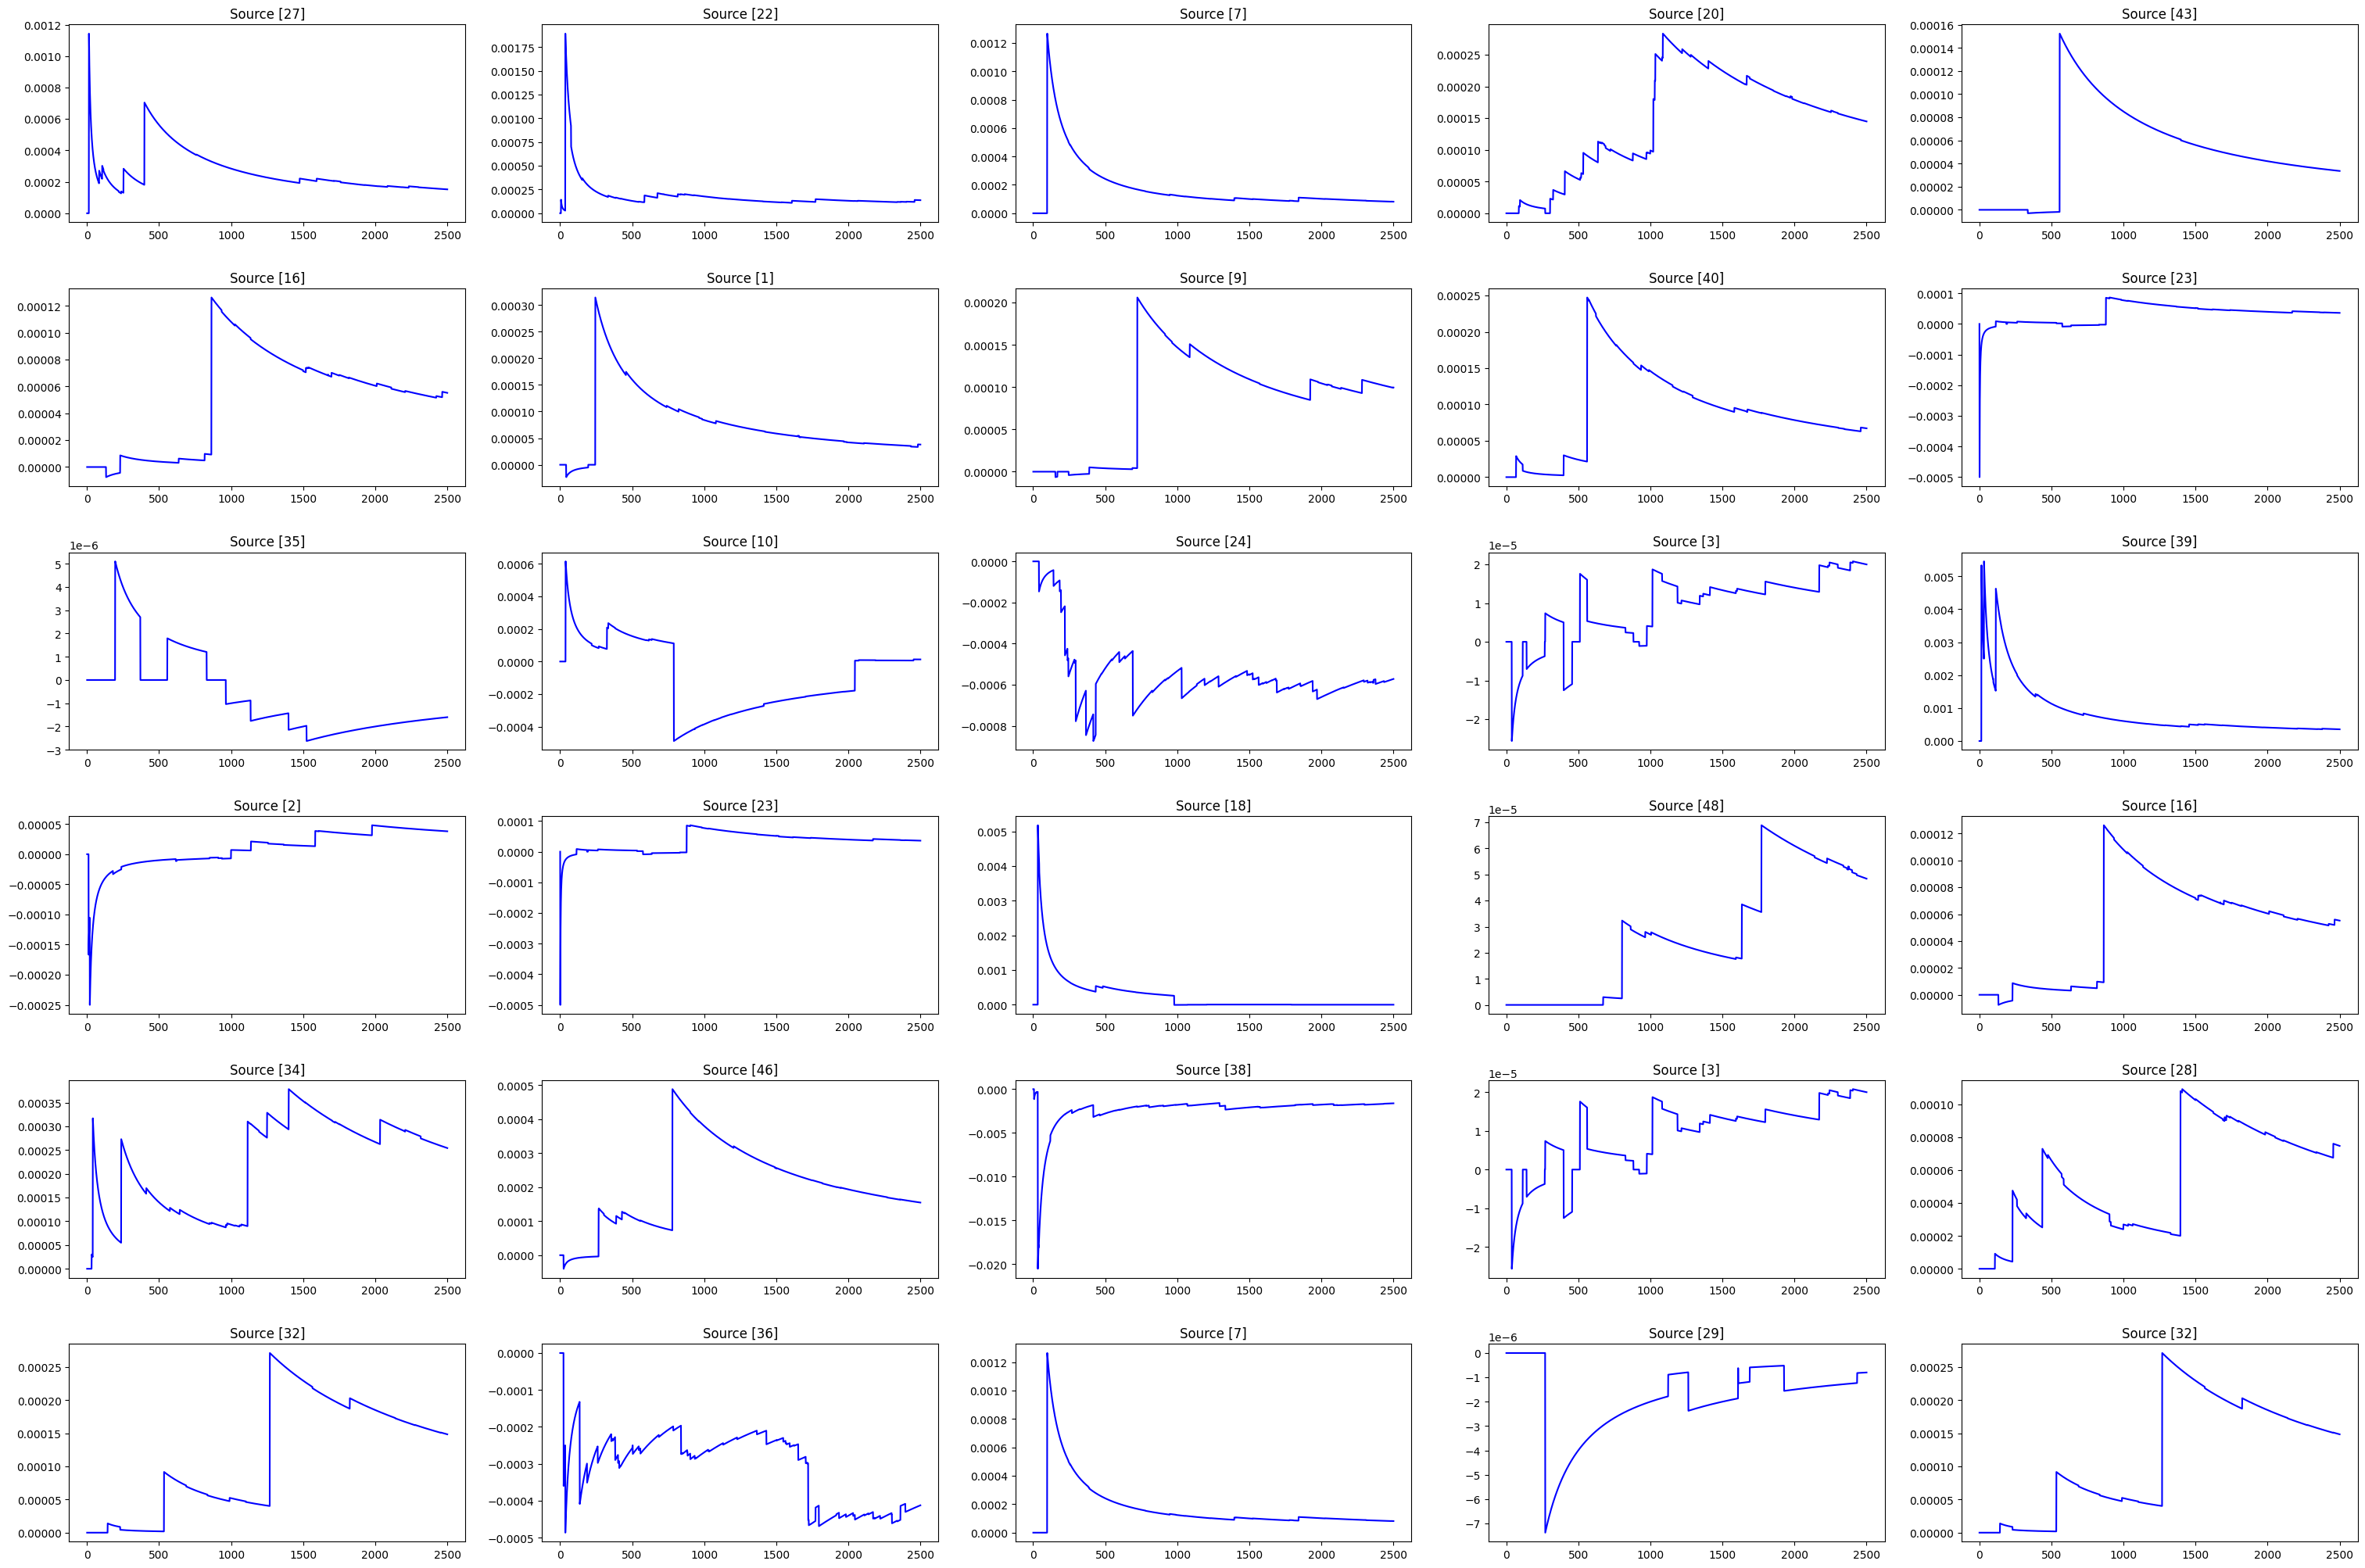

In [81]:
% matplotlib inline
conv_plots_1000_train = dshap_1000_train.convergence_plots(source_indexes, figsize=(30, 20), h_pad=4, w_pad=4,
                                                           plot_more_than_25=True)
conv_plots_1000_train.savefig('./plots/conv_plots_1000_train.png', dpi=150)

Plots for 500 training datapoints.

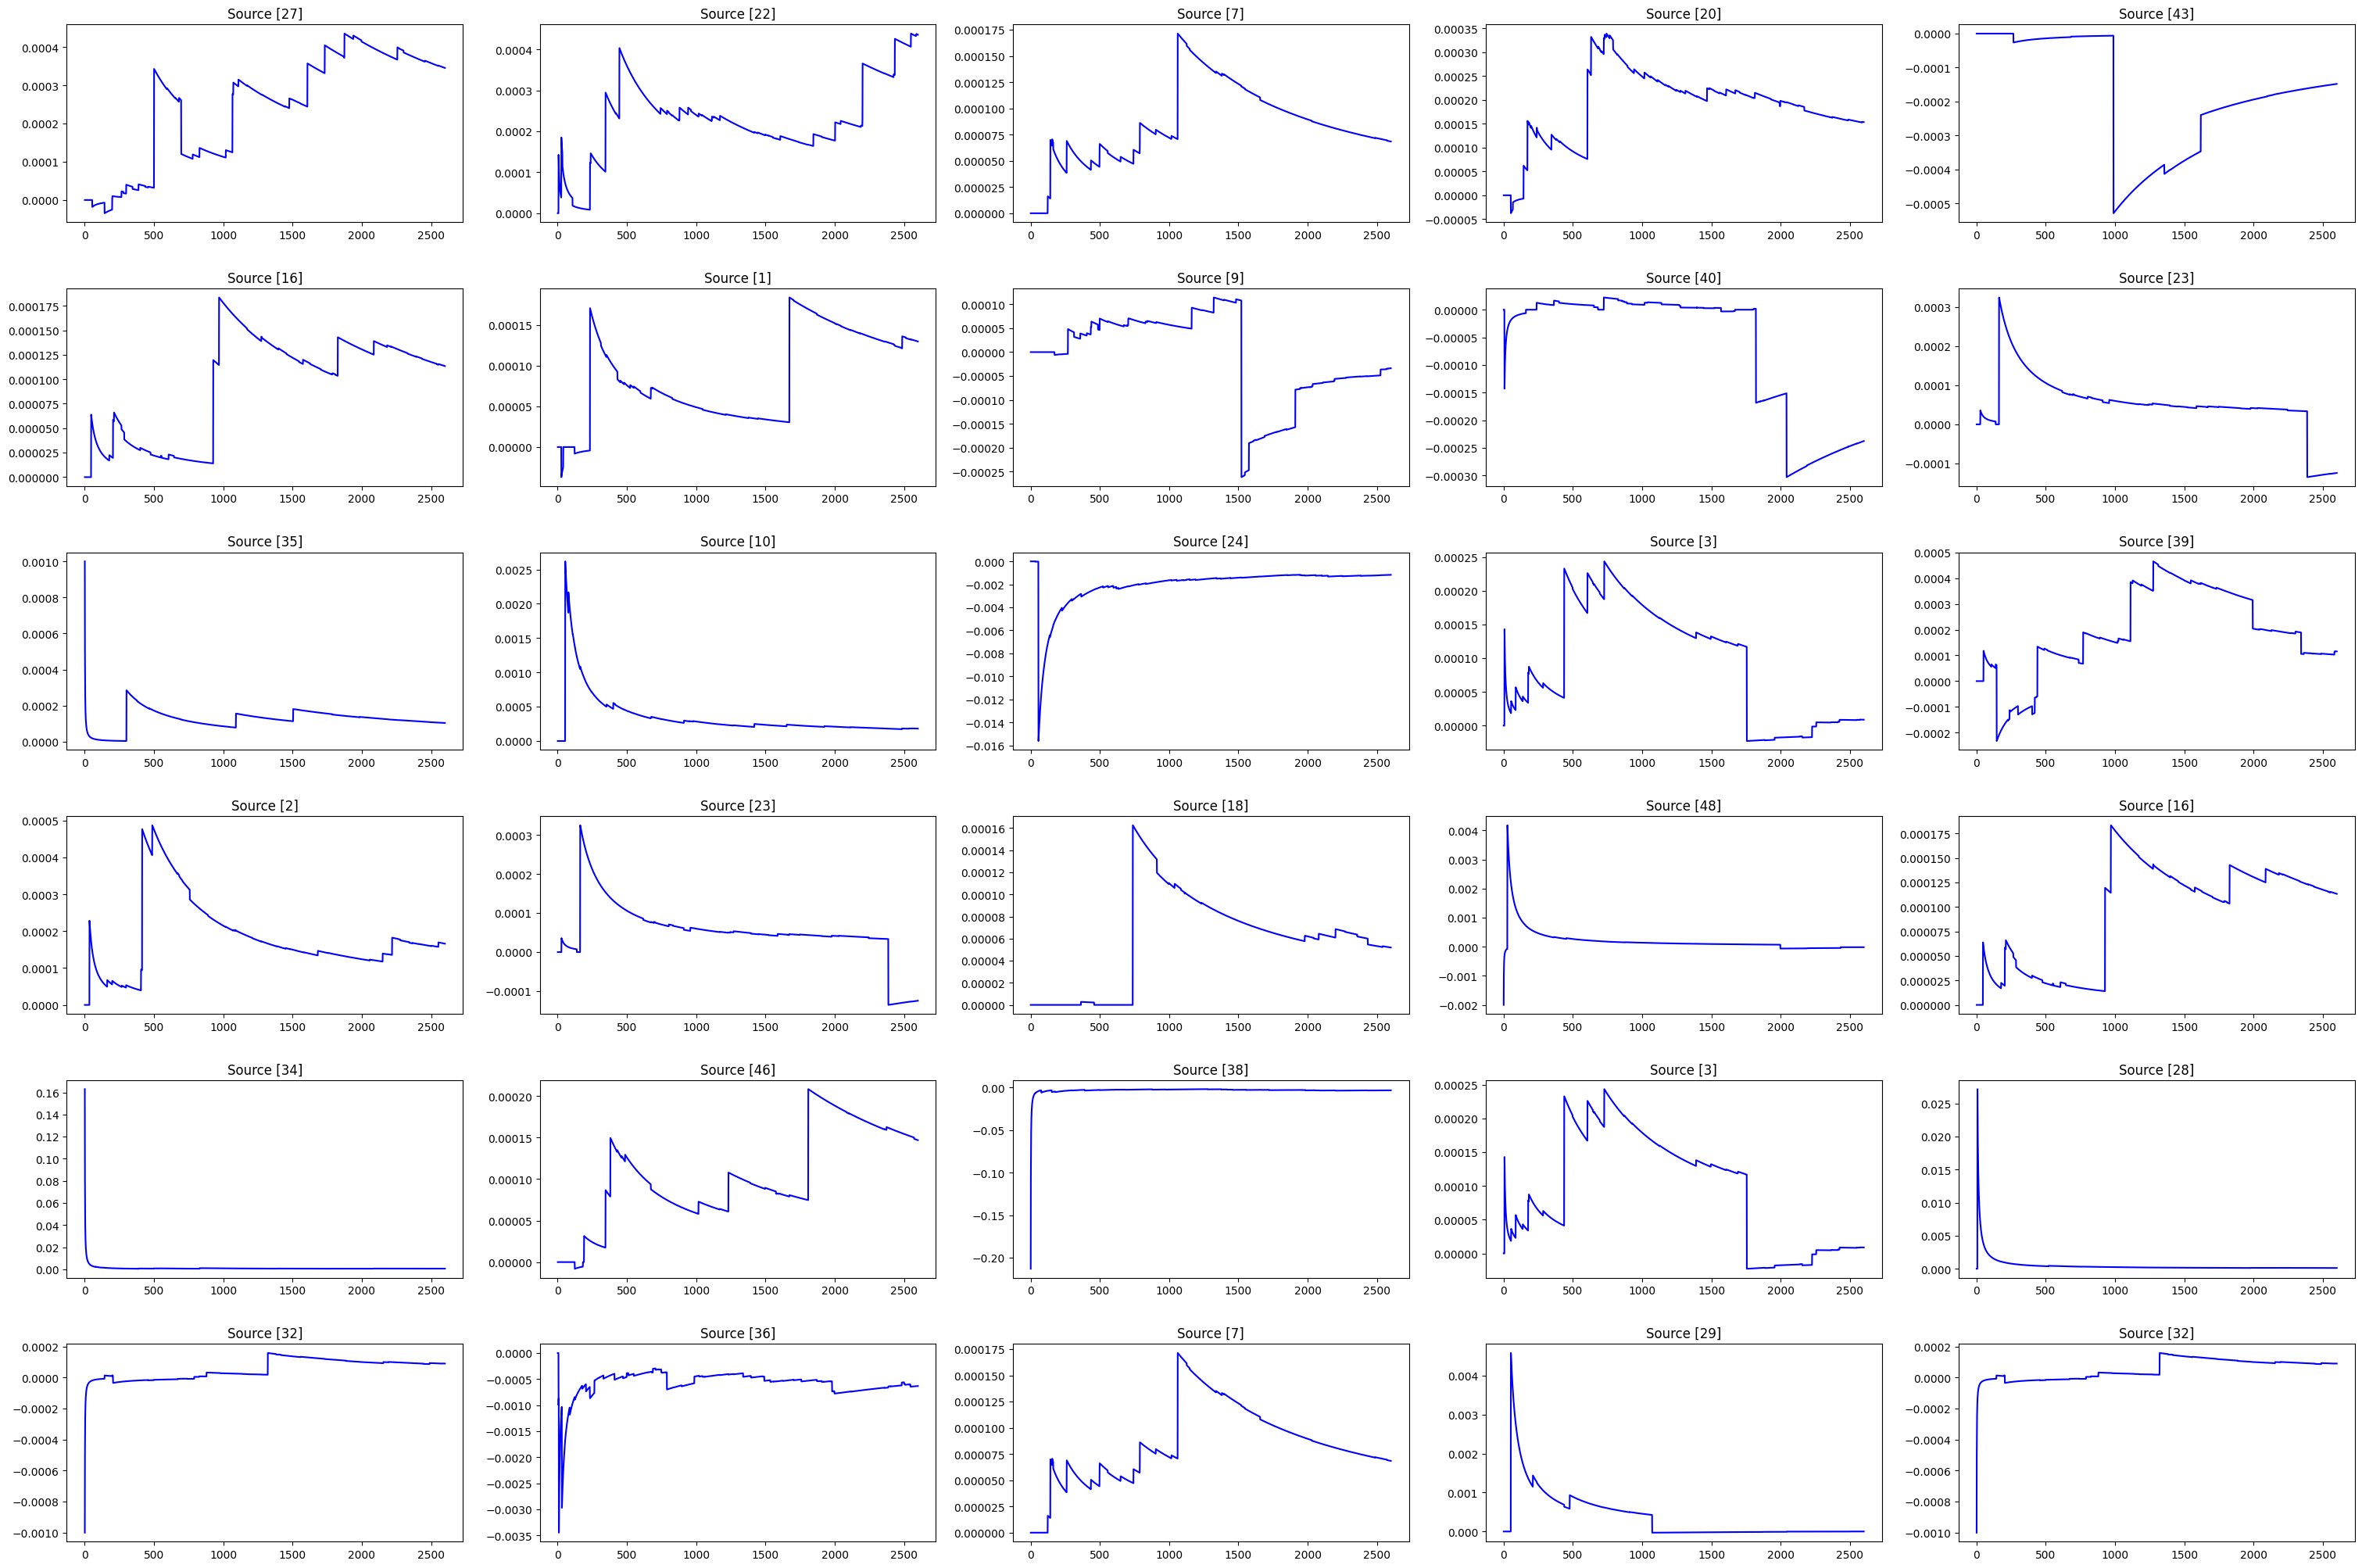

In [74]:
% matplotlib inline
conv_plots_500_train = dshap_500_train.convergence_plots(source_indexes, figsize=(30, 20), h_pad=4, w_pad=4,
                                                         plot_more_than_25=True)
conv_plots_500_train.savefig('./plots/conv_plots_500_train.png', dpi=150)

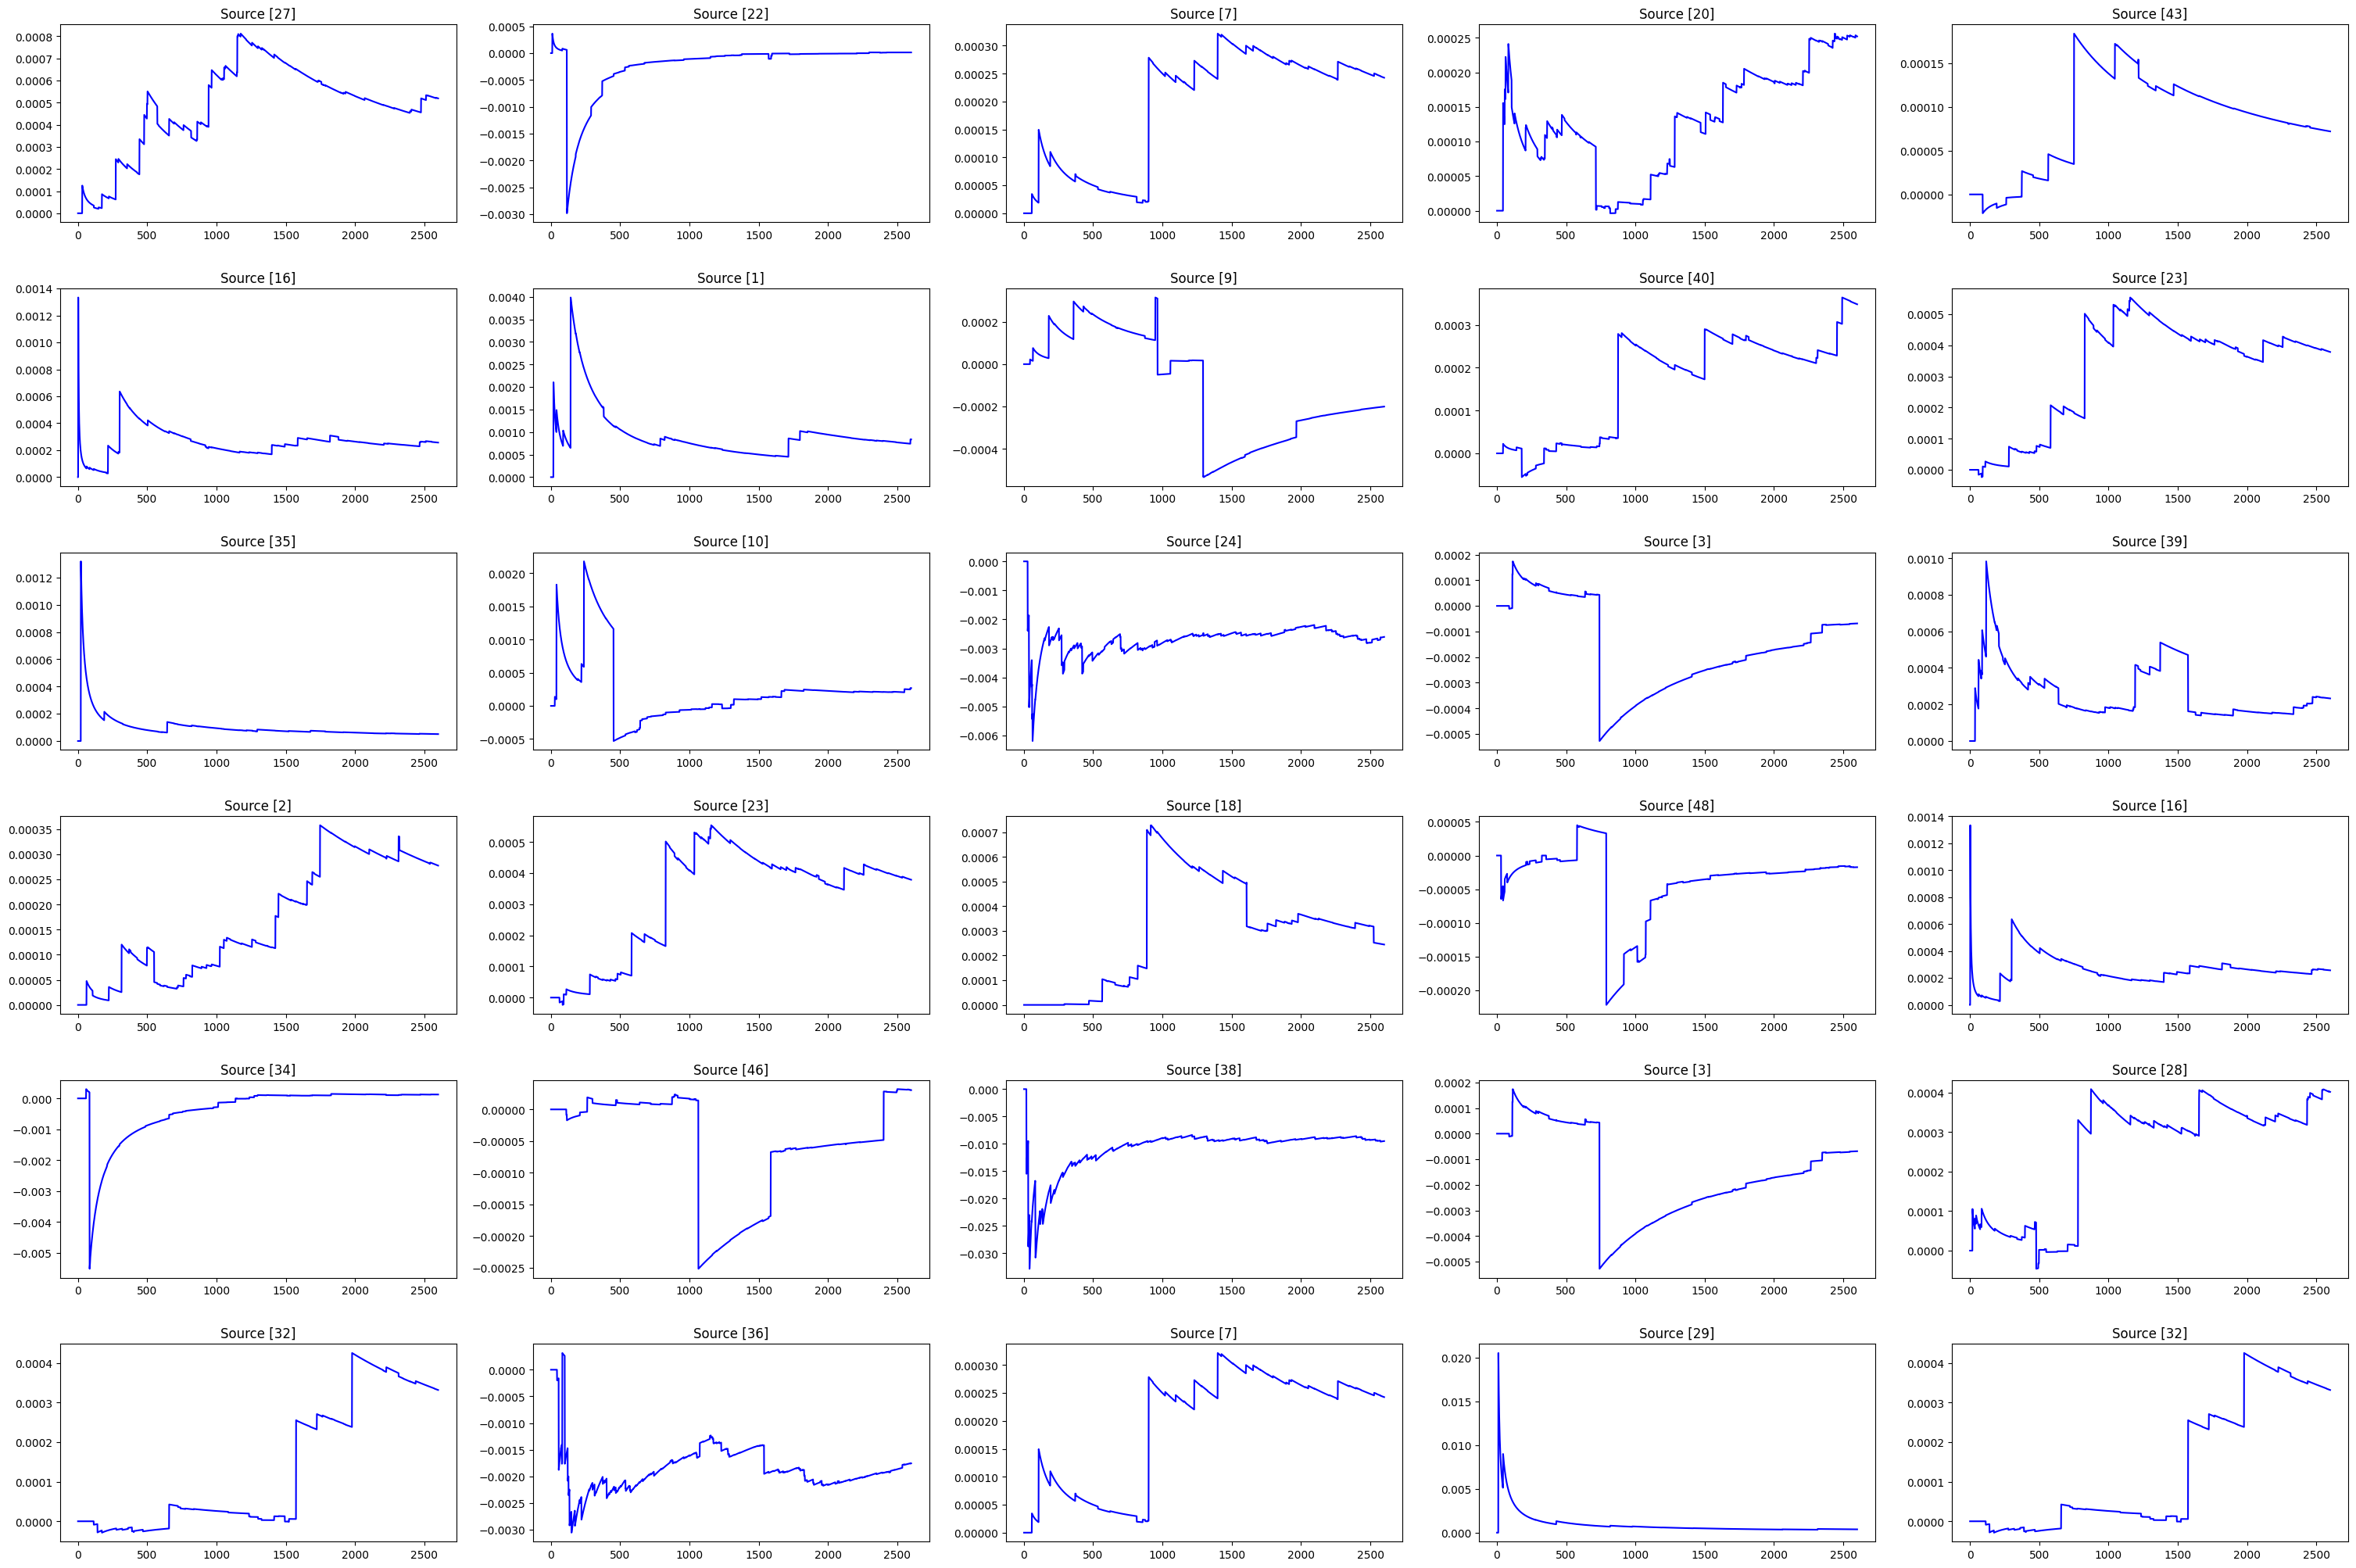

In [75]:
% matplotlib inline
conv_plots_200_train = dshap_200_train.convergence_plots(source_indexes, figsize=(30, 20), h_pad=4, w_pad=4,
                                                         plot_more_than_25=True)
conv_plots_200_train.savefig('./plots/conv_plots_200_train.png', dpi=150)

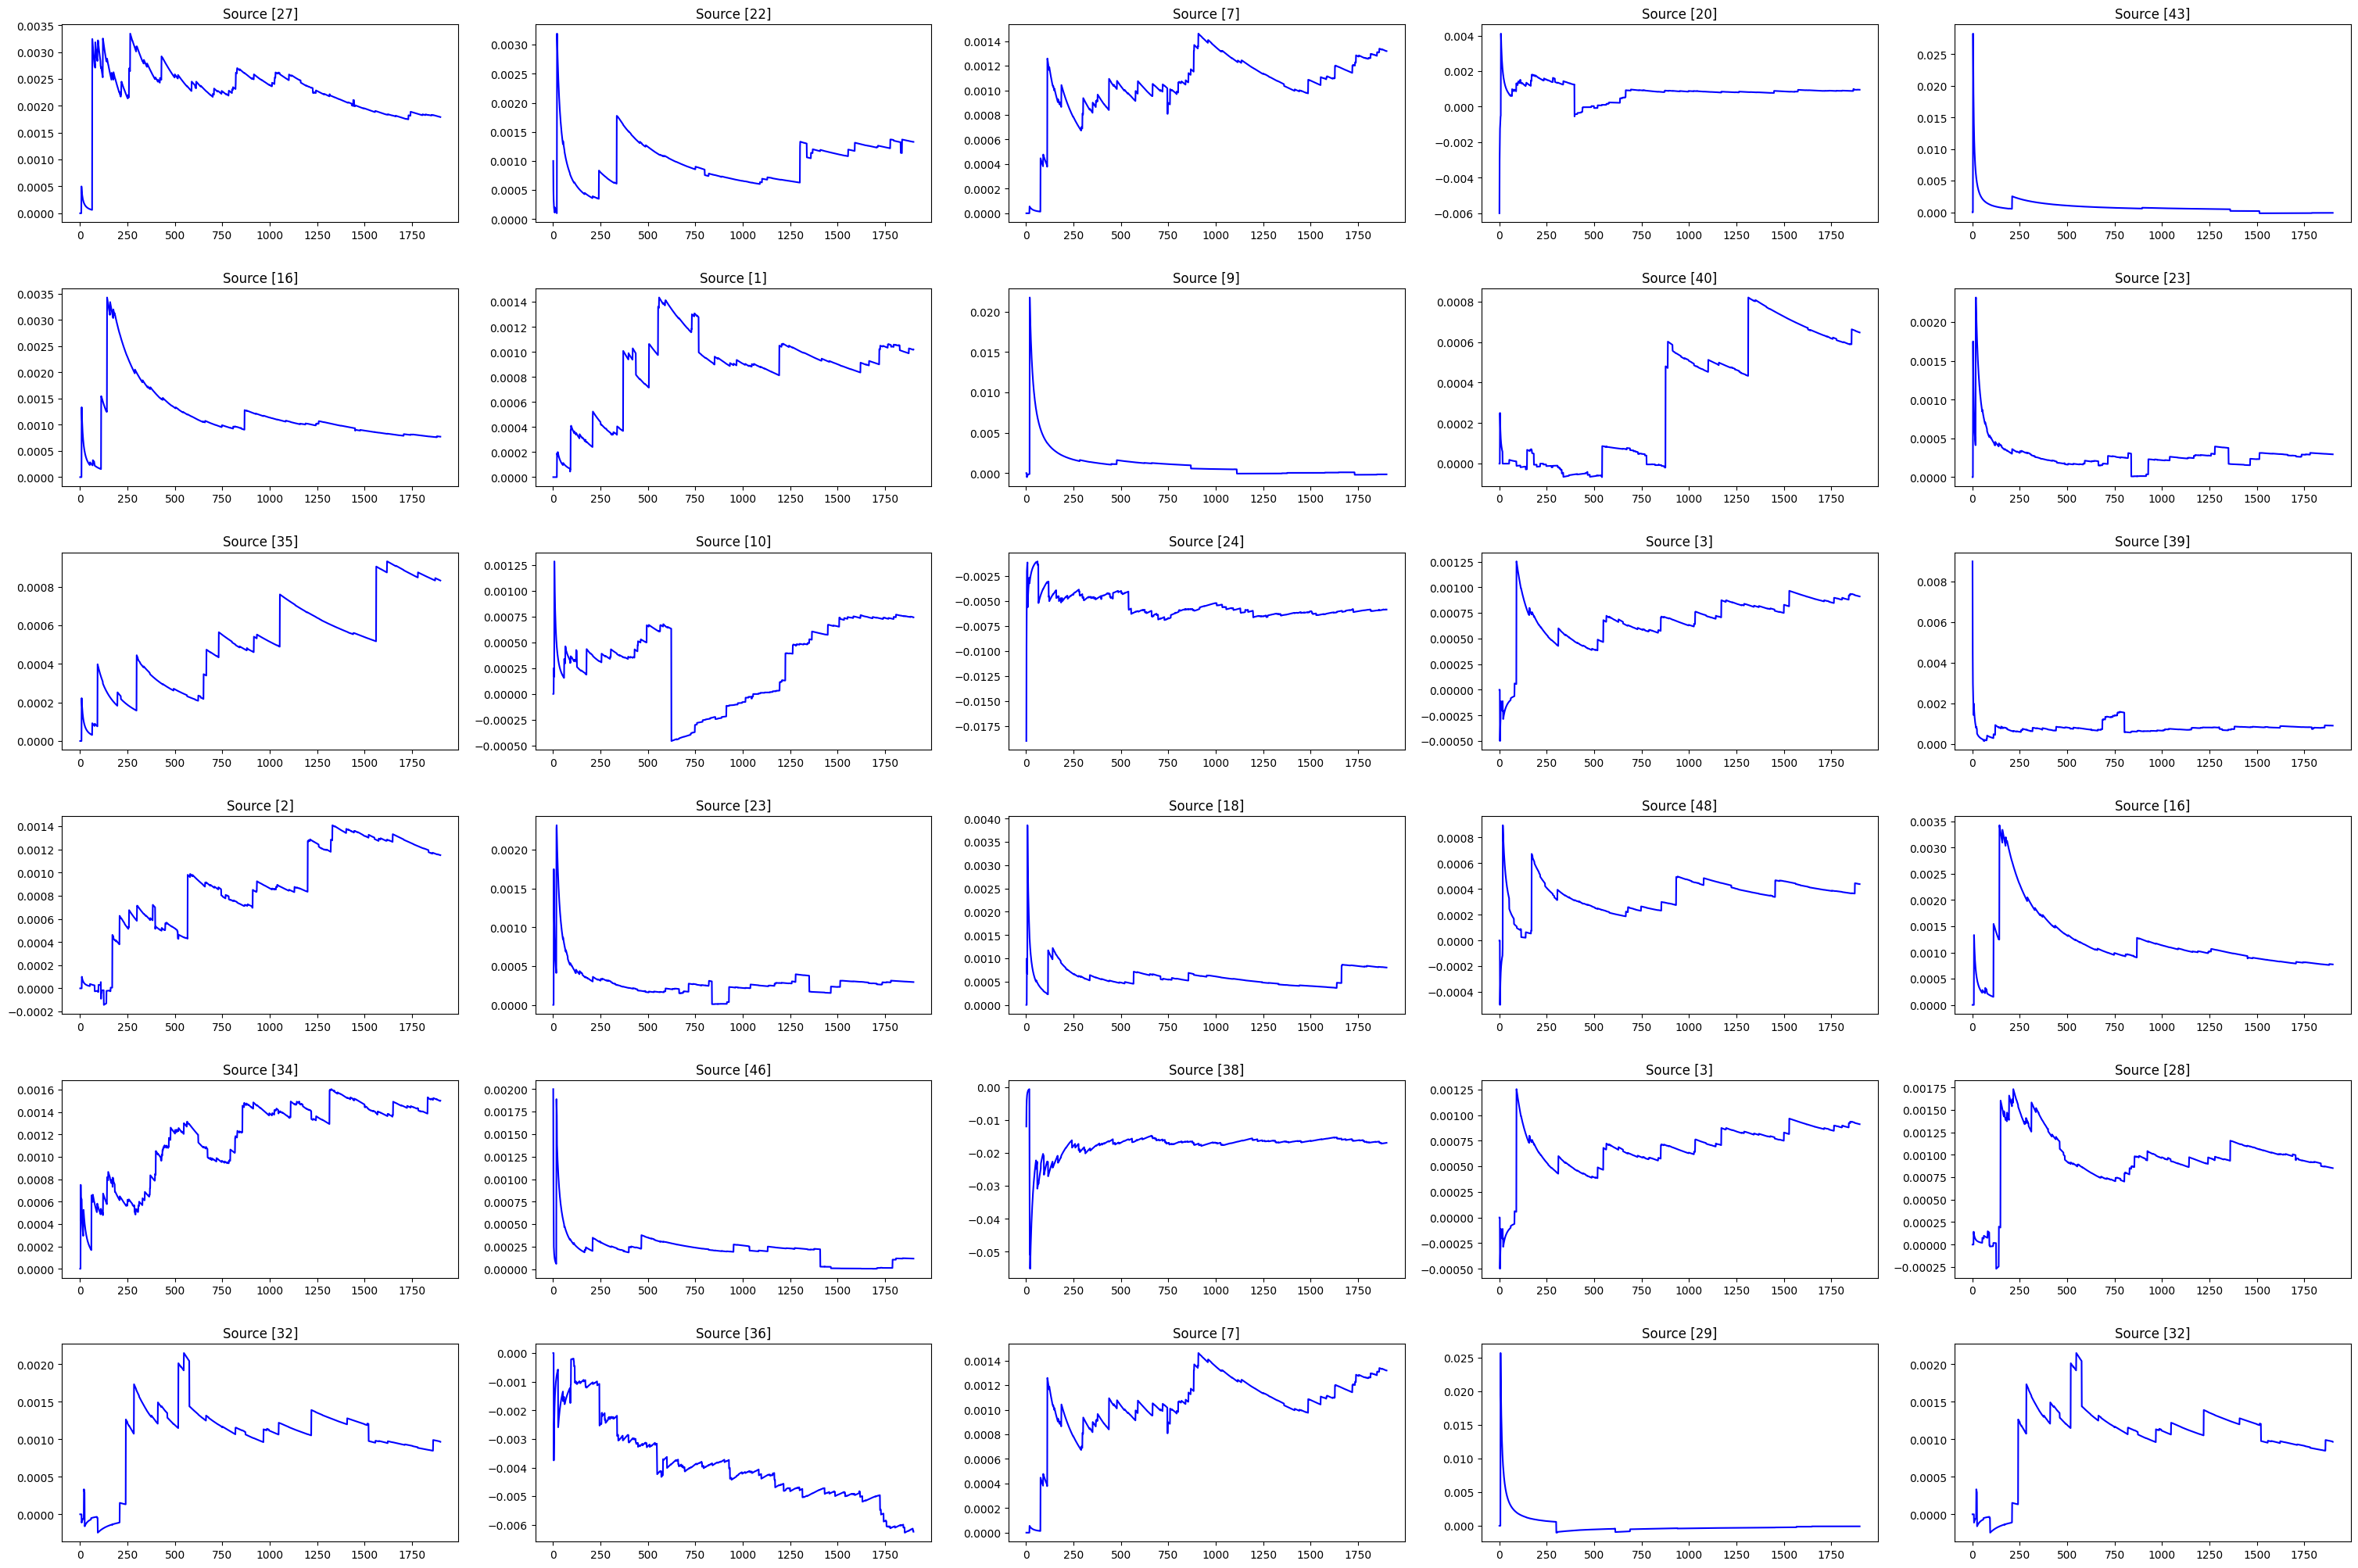

In [76]:
% matplotlib inline
conv_plots_100_train = dshap_100_train.convergence_plots(source_indexes, figsize=(30, 20), h_pad=4, w_pad=4,
                                                         plot_more_than_25=True)
conv_plots_100_train.savefig('./plots/conv_plots_100_train.png', dpi=150)

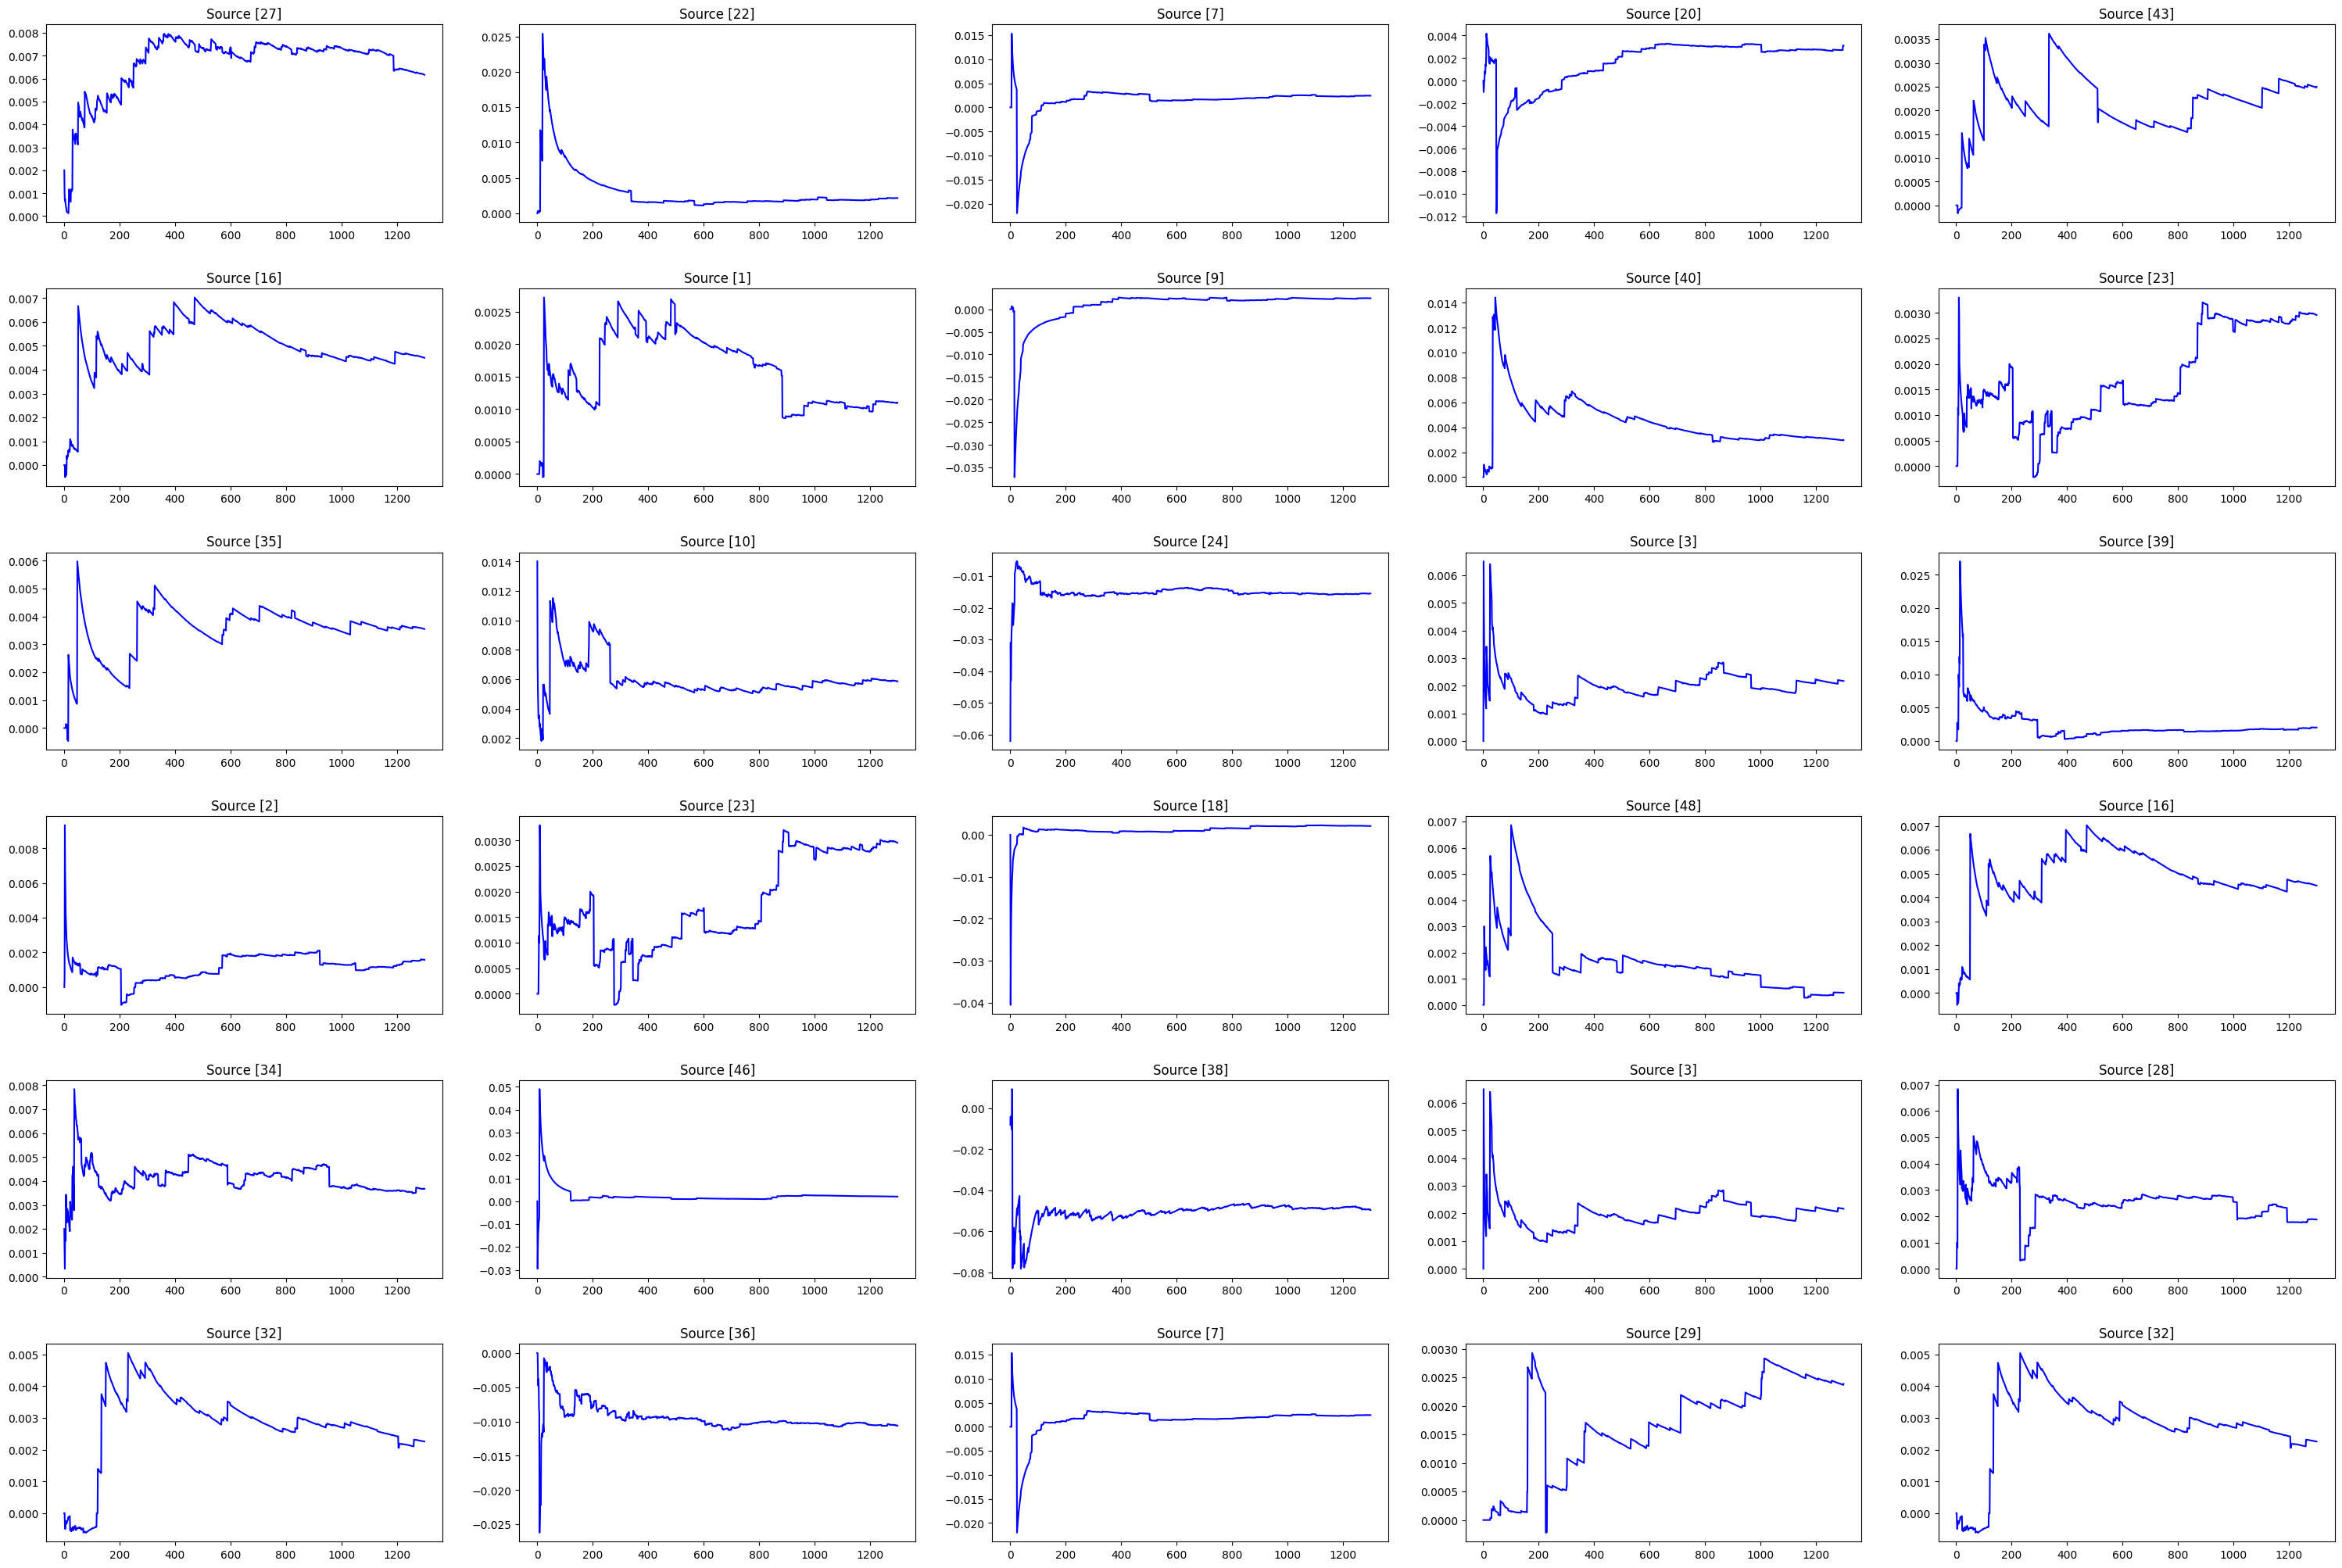

In [77]:
% matplotlib inline
conv_plots_50_train = dshap_50_train.convergence_plots(source_indexes, figsize=(30, 20), h_pad=4, w_pad=4,
                                                       plot_more_than_25=True)
conv_plots_50_train.savefig('./plots/conv_plots_50_train.png', dpi=150)

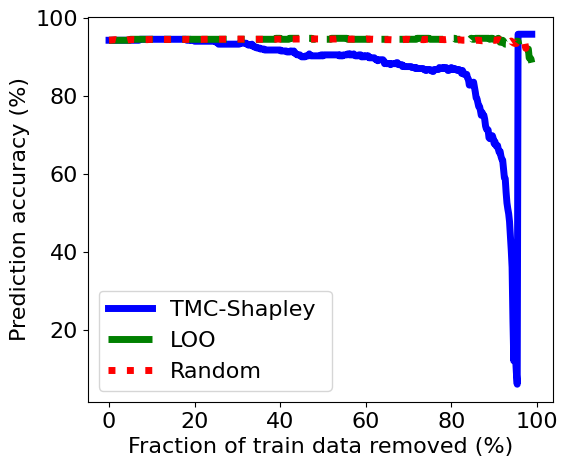

In [83]:
% matplotlib inline
dshap_1000_train.performance_plots([dshap_1000_train.vals_tmc, dshap_1000_train.vals_loo],
                                   num_plot_markers=train_size // 2,
                                   sources=None, figsize=(6, 5), fontsize=16)

In [90]:
dshap_1000_train.vals_tmc[dshap_1000_train.vals_tmc >= 0].size

799

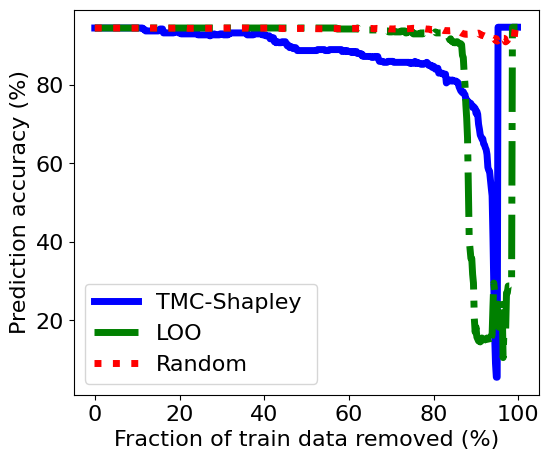

In [91]:
% matplotlib inline
dshap_500_train.performance_plots([dshap_500_train.vals_tmc, dshap_500_train.vals_loo],
                                  num_plot_markers=train_size // 2,
                                  sources=None, figsize=(6, 5), fontsize=16)

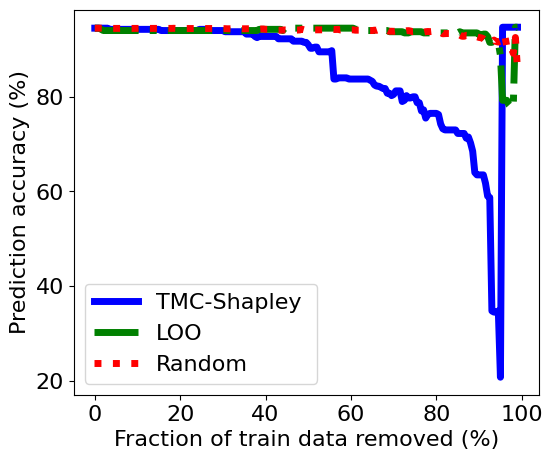

In [92]:
% matplotlib inline
dshap_200_train.performance_plots([dshap_200_train.vals_tmc, dshap_200_train.vals_loo],
                                  num_plot_markers=train_size // 2,
                                  sources=None, figsize=(6, 5), fontsize=16)

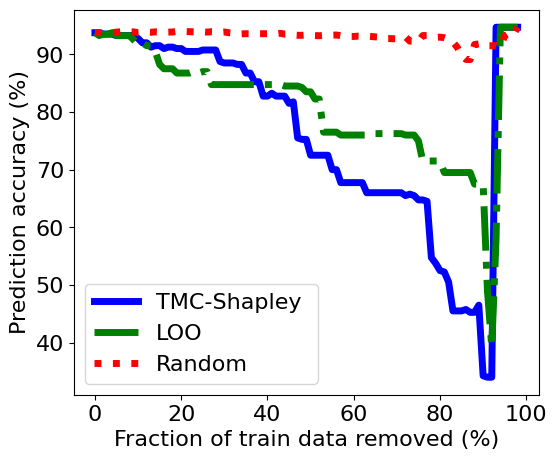

In [93]:
% matplotlib inline
dshap_100_train.performance_plots([dshap_100_train.vals_tmc, dshap_100_train.vals_loo],
                                  num_plot_markers=train_size // 2,
                                  sources=None, figsize=(6, 5), fontsize=16)

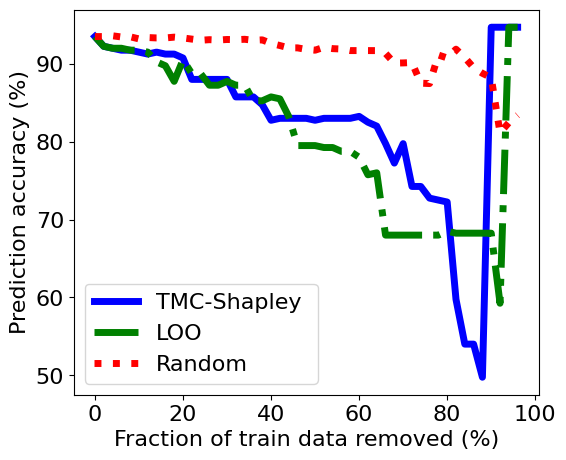

In [94]:
% matplotlib inline
dshap_50_train.performance_plots([dshap_50_train.vals_tmc, dshap_50_train.vals_loo], num_plot_markers=train_size // 2,
                                 sources=None, figsize=(6, 5), fontsize=16)

# Notes

## Test set size

1. Test set size is small $\implies$ evaluation can change drastically as we add more datapoints during one iteration of TMC-Shapley. This means truncation might happen rarely.

2. Test set size is large $\implies$ evaluation does not change too much as we add datapoints during one iteration. Truncation might lead to significant optimization.